In [86]:
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from HW2 import *

# 0. Read image

In [87]:
imgLeftName  = 'm1'
imgRightName = 'm2'
imgLeft,  imgLeft_gray,  imgLeft_rgb  = read_img('test/{}.jpg'.format(imgLeftName))
imgRight, imgRight_gray, imgRight_rgb = read_img('test/{}.jpg'.format(imgRightName))

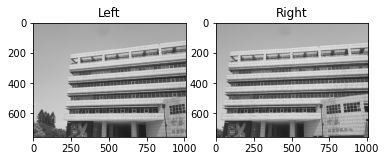

In [88]:
plt.subplot(1, 2, 1)
plt.title('Left')
plt.imshow(imgLeft_gray, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Right')
plt.imshow(imgRight_gray, cmap='gray')

plt.show()

# 1. Detecting key point(feature) on the images


In [89]:
def SIFT(img):
    SIFT_Detector = cv2.SIFT_create()
    kp, des = SIFT_Detector.detectAndCompute(img, None)

    return kp, des

def plot_sift(gray, rgb, kp):
    tmp = rgb.copy()
    img = cv2.drawKeypoints(image=gray, 
                            keypoints=kp, 
                            outImage=tmp, 
                            color=(255,0,0), 
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG)
    return img

In [90]:
kpsLeft, dessLeft   = SIFT(imgLeft_gray)
kpsRight, dessRight = SIFT(imgRight_gray)

kp_left_img  = plot_sift(imgLeft_gray, imgLeft_rgb, kpsLeft)
kp_right_img = plot_sift(imgRight_gray, imgRight_rgb, kpsRight)
# total_kp = np.concatenate((kp_left_img, kp_right_img), axis=1)

# plt.title('Left                                     Right')
# plt.imshow(total_kp)
# plt.show()

# 2. Finding features correspondences (feature matching)

In [91]:
def Knn(dessLeft, dessRight):
    '''
    Finding the K closest neighbors to the target. 
    Brute-force : Comparing with the all 2-norm of SIFT feature (the 2-norm of descriptor)

    input:
        :dessLeft : left  picture descriptors from SIFT
        :dessRight: right picture descriptors from SIFT
    output:
        :matches: 
            [left SIFT feature index,[D1 right SIFT featrue index, D1 distance],[D2 right SIFT featrue index, D2 distance]]
    '''
    matches = []
    for i, desLeft in tqdm(enumerate(dessLeft)):
        D1 = [None,100000]
        D2 = [None,100000]
        for j, desRight in enumerate(dessRight):
            # Euclidean distance
            destemp = np.linalg.norm(desLeft-desRight)  
            if D2[1] > destemp:
                if D1[1] > destemp:
                    D2 = D1
                    D1 = [j,destemp]
                else:
                    D2 = [j,destemp]
        matches.append([i,D1,D2])
    print("經過knn 的matches數量:", len(matches))
    return matches
    

In [92]:
def LoweRatioTest(matches, threshold=0.5):
    '''
    Lowe’s Ratio test for eliminating bad match. 
    1. For every key point P in image1 using 2NN to get 2 matched key points P1 & P2 in image2
    2. Computing the 2-norm of P1 & P2 between P named D1 , D2
    3. If D1 < threshold * D2 then P1 is a good match

    input:
        :matches  : from knn
        :threshold: ratio between 0 to 1
    output:
        :good_matches: left picture coordinate & right picture coordinate
                       [[x_left, y_left, x_right, y_right],....]
    '''
    good_matchs = []
    for match in matches:
        kpleft_ID = match[0]
        D1_ID     = match[1][0]
        D1_dis    = match[1][1]
        D2_ID     = match[2][0]
        D2_dis    = match[2][1]

        # Lowe’s Ratio test 
        if D1_dis < threshold * D2_dis:
            good_matchs.append(list(kpsLeft[kpleft_ID].pt + kpsRight[D1_ID].pt))

    print("經過Lowe’s Ratio test 的good matches數量:", len(good_matchs))
    good_matchs = np.array(good_matchs)
    return good_matchs


def plot_matches(matches, total_img):
    match_img = total_img.copy()
    offset = total_img.shape[1]/2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(match_img).astype('uint8')) #　RGB is integer type
    
    ax.plot(matches[:, 0], matches[:, 1], 'xr')
    ax.plot(matches[:, 2] + offset, matches[:, 3], 'xr')
     
    ax.plot([matches[:, 0], matches[:, 2] + offset], [matches[:, 1], matches[:, 3]],
            'r', linewidth=0.5)
    plt.title('Left                                     Right')
    plt.show()

In [93]:
def matcher(kp1, des1, img1, kp2, des2, img2, threshold):
    # BFMatcher with default params
    bf = cv2.BFMatcher()                                      # TODO: 不能用套件，這要手寫
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        # print('m=',m.distance,'n=',n.distance)
        if m.distance < threshold*n.distance:
            good.append([m])
    print(len(good))
    matches = []
    for pair in good:
        matches.append(list(kp1[pair[0].queryIdx].pt + kp2[pair[0].trainIdx].pt))

    matches = np.array(matches)     # matches是兩張圖片分別座標
    return matches

In [94]:
good_matches = matcher(kpsLeft, dessLeft, imgLeft_rgb, kpsRight, dessRight, imgRight_rgb, 0.5)
# total_img = np.concatenate((imgLeft_rgb, imgRight_rgb), axis=1)
# plot_matches(good_matches, total_img) # Good mathces

# 自己寫的
# matches_test = Knn(dessLeft, dessRight)
# good_matches  = LoweRatioTest(matches_test)
# total_img = np.concatenate((imgLeft_rgb, imgRight_rgb), axis=1)

# plot_matches(good_matches, total_img) # Good mathces


227


# 3. Computing homography matrix.


In [95]:
def random_pairs(matches, n=4):
    idx = random.sample(range(len(matches)), n)
    pairs = [matches[i] for i in idx ]
    return np.array(pairs)


def homography(pairs):
    '''
    1. Construct a linear system as: P2=HP1, P2 = (x2,y2,1) , P1 = (x1,y1,1) where P2 and P1 are correspondence points,
       H is homography matrix.
    2. For perspective transformation , you can use 4 pairs of match result to slove 8 unknow variable in homography matrix
    3. Using SVD decomposition to find Least Squares error solution 
    4. the solution = eigenvector of associated with the smallest eigenvalue (V stores the eigenvector of , 
       stores the singular value (root of eigenvalue)) find the smallest number in and H = corresponding vector in VT
    5. Remember to normalize h33 to 1
    
    input:
        :pairs: 4 pairs
    output:
        :H: homography matrix(3,3)
    '''
    A = np.zeros((8,9))
    pointer_a = 0
    pointer_b = 4
    for i in range(pairs.shape[0]):
        
        x1   = pairs[i][0]
        y1   = pairs[i][1]
        x1_b = pairs[i][2]
        y1_b = pairs[i][3]

        A[pointer_a][0] = x1 
        A[pointer_a][1] = y1
        A[pointer_a][2] = 1
        A[pointer_a][6] = -x1*x1_b
        A[pointer_a][7] = -y1*x1_b
        A[pointer_a][8] = -x1_b
        
        A[pointer_b][3] = x1 
        A[pointer_b][4] = y1
        A[pointer_b][5] = 1
        A[pointer_b][6] = -x1*y1_b
        A[pointer_b][7] = -y1*y1_b
        A[pointer_b][8] = -y1_b

        pointer_a += 1
        pointer_b += 1

    U, s, V = np.linalg.svd(A)   # SVD eigenvalue 由大到小排列，且h的解是「the eigenvector of ATA associated with the smallest eigenvalue」，所以選V最後一個eigenvector
    H = V[-1].reshape(3, 3)
    H = H/H[2, 2]     # standardize to let w*H[2,2] = 1
    return H


def get_error(points, H):
    num_points = len(points)
    all_p1 = np.concatenate((points[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = points[:, 2:4]
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i])
        estimate_p2[i] = (temp/temp[2])[0:2] # set index 2 to 1 and slice the index 0, 1
    # Compute error
    errors = np.linalg.norm(all_p2 - estimate_p2 , axis=1) ** 2

    return errors
    

def ransac(good_matches, threshold, iters=2000):
    '''
    1. 隨機挑出要計算出 Homography H 所需的最少個的點。
    2. 求出 Homography H 的解
    3. 將所有 Good matching 特徵配對去計算 P=HP'估，並統計有多少對在容許內的誤差範圍，並稱為 Inliers。
    4. 接著用這個 H 去算誤差 ∥P'估-P'真∥ ，如果誤差比規定的門檻還小，我們可以相信這次結果是可靠的。若為可靠，
       那麼統計這次 Inliers 數量有沒有比最佳次數還多，有的話我們就更新最佳 H 和最佳 Inliers 數量。
    5. 反覆進行步驟 1 到 4 反覆 N 次，並取得最佳 H。

    input:
        :good matches: from knn
        :threshold   : ratio between 0 to 1
        :iters       : iters
    output:
        :best_inliers: best inliers points
        :best_H      : best H(3,3)
    '''
    num_best_inliers = 0
    
    for i in range(iters):
        pairs = random_pairs(good_matches)   # 隨機挑選四個最佳配對，計算Homography
        H = homography(pairs)
        
        #  avoid dividing by zero 
        if np.linalg.matrix_rank(H) < 3:
            continue
            
        errors = get_error(good_matches, H)
        idx = np.where(errors < threshold)[0]
        inliers = good_matches[idx]

        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_H = H.copy()
            
    print("inliers/matches: {}/{}".format(num_best_inliers, len(good_matches)))
    return best_inliers, best_H

In [96]:
# def homography(pairs):
#     rows = []
#     for i in range(pairs.shape[0]):
#         p1 = np.append(pairs[i][0:2], 1)
#         p2 = np.append(pairs[i][2:4], 1)
#         row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
#         row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
#         rows.append(row1)
#         rows.append(row2)
#     rows = np.array(rows)
#     U, s, V = np.linalg.svd(rows)
#     H = V[-1].reshape(3, 3)   
#     # print(H)
#     H = H/H[2, 2] # standardize to let w*H[2,2] = 1
#     return H

In [97]:
inliers, H = ransac(good_matches, 0.5, 10000)
# plot_matches(inliers, total_img) # show inliers matches

inliers/matches: 120/227


# 4. Stitching image (warp images into same coordinate system)

In [100]:
def stitch_img(left, right, H):
    
    # Convert to double and normalize. Avoid noise.
    left = cv2.normalize(left.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)   
    # Convert to double and normalize.
    right = cv2.normalize(right.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)   
    
    # left image
    height_l, width_l, channel_l = left.shape
    corners = [[0, 0, 1], [width_l, 0, 1], [width_l, height_l, 1], [0, height_l, 1]]
    corners_new = [np.dot(H, corner) for corner in corners]
    corners_new = np.array(corners_new).T        # [wx', wy', w]
    x_news = corners_new[0] / corners_new[2]     # x' = wx'/w
    y_news = corners_new[1] / corners_new[2]     # y' = wy'/w
    y_min = min(y_news)
    x_min = min(x_news)

    translation_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    H = np.dot(translation_mat, H)
    
    # Get height, width
    height_new = int(round(abs(y_min) + height_l))
    width_new = int(round(abs(x_min) + width_l))
    size = (width_new, height_new)

    warped_l = cv2.warpPerspective(src=left, M=H, dsize=size)
    
    # right image
    height_r, width_r, channel_r = right.shape
    height_new = int(round(abs(y_min) + height_r))
    width_new = int(round(abs(x_min) + width_r))
    size = (width_new, height_new)
    
    warped_r = cv2.warpPerspective(src=right, M=translation_mat, dsize=size)
     
    black = np.zeros(3)  # Black pixel.
    
    # Stitching procedure, store results in warped_l.
    for i in tqdm(range(warped_r.shape[0])):
        for j in range(warped_r.shape[1]):
            pixel_l = warped_l[i, j, :]
            pixel_r = warped_r[i, j, :]
            
            if np.sum(pixel_l)>=np.sum(pixel_r):
                warped_l[i, j, :] = pixel_l
            else:
                warped_l[i, j, :] = pixel_r
                  
    stitch_image = warped_l[:warped_r.shape[0], :warped_r.shape[1], :]
    return stitch_image

  0%|          | 0/806 [00:00<?, ?it/s]

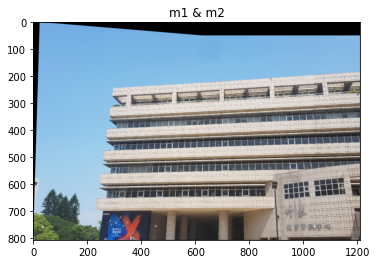

In [101]:
stitchImg = stitch_img(imgLeft_rgb, imgRight_rgb, H)

plt.title('{} & {}'.format(imgLeftName, imgRightName))
plt.imshow(stitchImg)
plt.imsave('test/{}{}.jpg'.format(imgLeftName,imgRightName), stitchImg)